In [1]:
import os
import optuna
import numpy as np
import pandas as pd
import sys
from matplotlib import pyplot as plt
fontsize = 8
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from materialdatabase.material_data_base_functions import load_material_from_db, p_hyst__from_mu_r_and_mu_phi_deg, write_steinmetz_data_into_database, my_polate_linear
from materialdatabase.constants import mu_0, epsilon_0

def steinmetz(freq, b_max, alpha, beta, k):
    return k*freq**alpha*b_max**beta


c:\Users\tpiepe\Repositories\materialdatabase\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
material = load_material_from_db("N95")
measurements = material["measurements"]["complex_permeability"]["LEA_LK"]["measurement_data"]
df_measurements = pd.DataFrame()  
list_of_dfs = []
for measurement in measurements:
    # dfItem = pd.read_json(measurement)              
    dfItem = pd.DataFrame.from_records(measurement)   
    list_of_dfs.append(dfItem)  

df_measurements = pd.concat(list_of_dfs, ignore_index=True)
print(df_measurements)

Read data from the data base.
     flux_density  frequency  mu_phi_deg     mu_r_abs  temperature
0        0.000000     100000    1.368385  1774.378590           30
1        0.002117     100000    1.525758  1804.408202           30
2        0.037407     100000    4.149405  2305.048636           30
3        0.072698     100000    6.515501  2709.172501           30
4        0.107988     100000    8.624045  3016.779797           30
..            ...        ...         ...          ...          ...
215      0.120961     500000   29.468798  3512.029015          100
216      0.144299     500000   31.360265  3430.707124          100
217      0.167636     500000   32.781618  3305.724686          100
218      0.190973     500000   33.732856  3137.081700          100
219      0.214310     500000   34.213981  2924.778167          100

[220 rows x 5 columns]


In [22]:
# Crop the data a bit
min_flux_density = 0.01
max_flux_density = 0.25

df_measurements = df_measurements.drop(df_measurements[df_measurements.flux_density < min_flux_density].index)
df_measurements = df_measurements.drop(df_measurements[df_measurements.flux_density > max_flux_density].index)


In [25]:
temperatures = sorted(list(df_measurements["temperature"].unique()))

best_params = {}

for temperature in temperatures:
    b_max = df_measurements.loc[(df_measurements["temperature"] == temperature)]["flux_density"].to_numpy()
    freq = df_measurements.loc[(df_measurements["temperature"] == temperature)]["frequency"].to_numpy()
    mu_r_abs = df_measurements.loc[(df_measurements["temperature"] == temperature)]["mu_r_abs"].to_numpy()
    mu_phi_deg = df_measurements.loc[(df_measurements["temperature"] == temperature)]["mu_phi_deg"].to_numpy()
    ploss = p_hyst__from_mu_r_and_mu_phi_deg(freq, b_max, mu_r_abs, mu_phi_deg)

    # estimated_loss = np.array(len(freq))
    def estimated_loss(alpha, beta, k):
        return steinmetz(freq, b_max, alpha, beta, k)

    def normalized_error(alpha, beta, k):
        return np.mean(np.abs((estimated_loss(alpha, beta, k)-ploss)/ploss))
        

    def objective(trial):
        aa = trial.suggest_float('aa', 1, 2)
        bb = trial.suggest_float('bb', 2, 4)
        kk = trial.suggest_float('kk', 0.1, 500)
        return normalized_error(aa, bb, kk)

    study = optuna.create_study()
    study.optimize(objective, n_trials=4000)

    best_params[f"{temperature}"] = study.best_params



[I 2023-06-14 13:51:55,661] A new study created in memory with name: no-name-846d4ce4-11b6-4466-b9c0-b1e7ea10186a
[I 2023-06-14 13:51:55,666] Trial 0 finished with value: 52.06830218980754 and parameters: {'aa': 1.4920865248961324, 'bb': 2.5379911309712213, 'kk': 78.82071401415891}. Best is trial 0 with value: 52.06830218980754.
[I 2023-06-14 13:51:55,668] Trial 1 finished with value: 25.221568385817797 and parameters: {'aa': 1.656419505672152, 'bb': 3.0325326595555286, 'kk': 13.802352193244854}. Best is trial 1 with value: 25.221568385817797.
[I 2023-06-14 13:51:55,670] Trial 2 finished with value: 7105.914646440711 and parameters: {'aa': 1.8462794494454715, 'bb': 3.1289774678793183, 'kk': 418.6981391134865}. Best is trial 1 with value: 25.221568385817797.
[I 2023-06-14 13:51:55,671] Trial 3 finished with value: 35.10629704141482 and parameters: {'aa': 1.5543107971873646, 'bb': 3.5487960658144293, 'kk': 181.34091683906996}. Best is trial 1 with value: 25.221568385817797.
[I 2023-06-14

{'30': {'aa': 1.6749933391123886, 'bb': 2.5234381055104413, 'kk': 0.15110174642556018}, '60': {'aa': 1.6274653097065075, 'bb': 2.759233347339567, 'kk': 0.41715126192811347}, '80': {'aa': 1.5883673755697614, 'bb': 2.4573015327727754, 'kk': 0.3783734499212979}, '100': {'aa': 1.3764378527974535, 'bb': 2.6765083020362566, 'kk': 8.14613780300291}}
normalized_error(params['aa'], params['bb'], params['kk']) = 0.07065176687864223
normalized_error(params['aa'], params['bb'], params['kk']) = 0.11341441497695916
normalized_error(params['aa'], params['bb'], params['kk']) = 0.0979258350688063
normalized_error(params['aa'], params['bb'], params['kk']) = 0.16489115180255315


<Figure size 300x300 with 0 Axes>

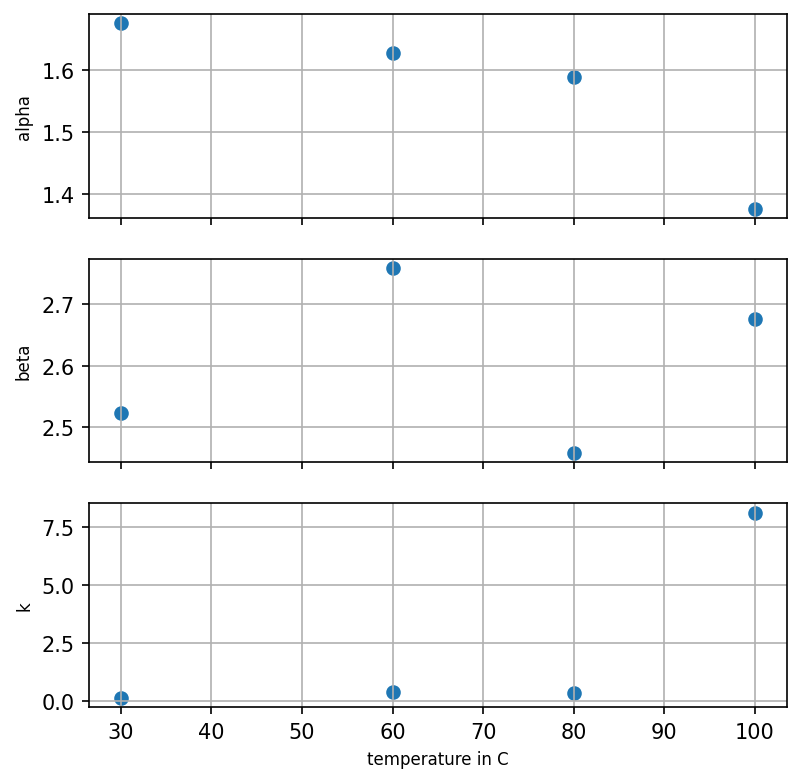

In [26]:
print(best_params)

# Plot some exemplary parts of the data
plt.figure(dpi=150, figsize=(2,2))

fig, axes = plt.subplots(nrows=3, dpi=150, sharex=True, sharey=False, figsize=(6, 6))

alphas = []
betas = []
ks = []

for temperature, params in best_params.items():
    alphas.append(params['aa'])
    betas.append(params['bb'])
    ks.append(params['kk'])
    print(f"{normalized_error(params['aa'], params['bb'], params['kk']) = }")
    
axes[0].scatter(temperatures, alphas)
axes[1].scatter(temperatures,betas)
axes[2].scatter(temperatures, ks)
axes[2].set_xlabel('temperature in C', fontsize=fontsize)
axes[0].set_ylabel("alpha", fontsize=fontsize)
axes[1].set_ylabel("beta", fontsize=fontsize)
axes[2].set_ylabel("k", fontsize=fontsize)

for i in range(0, 3):
    axes[i].grid()
plt.show()

In [2]:
results = {'30': {'aa': 1.6749933391123886, 'bb': 2.5234381055104413, 'kk': 0.15110174642556018}, '60': {'aa': 1.6274653097065075, 'bb': 2.759233347339567, 'kk': 0.41715126192811347}, '80': {'aa': 1.5883673755697614, 'bb': 2.4573015327727754, 'kk': 0.3783734499212979}, '100': {'aa': 1.3764378527974535, 'bb': 2.6765083020362566, 'kk': 8.14613780300291}}

print(results)
for temperature, params in results.items():S
    write_steinmetz_data_into_database(temperature=temperature, k=params['kk'], beta=params['bb'], alpha=params['aa'], 
                                       material_name="N95", measurement_setup="LEA_LK")

{'30': {'aa': 1.6749933391123886, 'bb': 2.5234381055104413, 'kk': 0.15110174642556018}, '60': {'aa': 1.6274653097065075, 'bb': 2.759233347339567, 'kk': 0.41715126192811347}, '80': {'aa': 1.5883673755697614, 'bb': 2.4573015327727754, 'kk': 0.3783734499212979}, '100': {'aa': 1.3764378527974535, 'bb': 2.6765083020362566, 'kk': 8.14613780300291}}


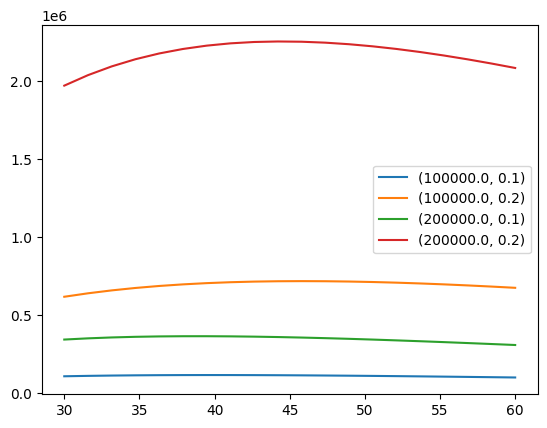

In [46]:
bs = np.linspace(0.1, 0.2, 2)
fs = np.linspace(100000, 200000, 2)
def my_polate_exp(a, b, f_a, f_b, x):
    """
    interpolates or extrapolates linear for a<x<b or x<a and x>b

    :param a: input x-value for point a
    :param b: input x-value for point b
    :param f_a: input y-value for point a
    :param f_b: input y-value for point b
    :param x: x-value for the searched answer f_x
    :return: y-value for given x-value
    """
    if a == b == x and f_a == f_b:
        f_x = f_a
    else:
        slope = (10**f_b - 10**f_a) / (b - a)
        f_x = slope * (x - a) + 10**f_a
    return np.log10(f_x)


ts = np.linspace(30, 60, 20)
for f in fs:
    for b in bs:
        p_t = []
        for t in ts:
            # alpha_t = 10**my_polate_linear(a=30, b=60, f_a=np.log10(results['30']['aa']), f_b=np.log10(results['60']['aa']), x=t)
            # beta_t = 10**my_polate_linear(a=30, b=60, f_a=np.log10(results['30']['bb']), f_b=np.log10(results['60']['bb']), x=t)
            # alpha_t = np.log10(my_polate_linear(a=30, b=60, f_a=10**(results['30']['aa']), f_b=10**(results['60']['aa']), x=t))
            # beta_t = np.log10(my_polate_linear(a=30, b=60, f_a=10**(results['30']['bb']), f_b=10**(results['60']['bb']), x=t))
            # alpha_t = my_polate_linear(a=30, b=60, f_a=results['30']['aa'], f_b=results['60']['aa'], x=t)
            # beta_t = my_polate_linear(a=30, b=60, f_a=results['30']['bb'], f_b=results['60']['bb'], x=t)
            
            alpha_t = my_polate_exp(a=30, b=60, f_a=results['30']['aa'], f_b=results['60']['aa'], x=t)
            beta_t = my_polate_exp(a=30, b=60, f_a=results['30']['bb'], f_b=results['60']['bb'], x=t)
            k_t = my_polate_linear(a=30, b=60, f_a=results['30']['kk'], f_b=results['60']['kk'], x=t)
            
            p_t.append(steinmetz(freq=f, b_max=b, alpha=alpha_t, beta=beta_t, k=k_t))
        plt.plot(ts, p_t, label=f"{f, b}")

# p_se_30 = steinmetz(freq=f, b_max=b, alpha=results['30']['aa'], beta=results['30']['bb'], k=results['30']['kk'])
# p_se_45 = steinmetz(freq=f, b_max=b, alpha=alpha_t, beta=beta_t, k=k_t)
# p_se_60 = steinmetz(freq=f, b_max=b, alpha=results['60']['aa'], beta=results['60']['bb'], k=results['60']['kk'])
plt.legend()
plt.show()
# print(f"{p_se_30 = }")
# print(f"{p_se_45 = }")
# print(f"{p_se_60 = }")